# Statistical Analysis of Data

## Environment Settings

An statistical Analysis of the data captured will be performed.

The environment configuration is the following:

- A rectangle area is used whose dimension is 2 x 1.5 meters. 
- A custom robot similar to an epuck was used.
- The robot starts in the middle of the arena.
- The robot moves in a random fashion way around the environment avoiding obstacles.
- The robot has 8 sensors that measure the distance between the robot and the walls.
- Some noise was introduced in the sensors measurements of the robot using the concept of [lookup tables](https://cyberbotics.com/doc/reference/distancesensor) in the Webots simulator which according to Webots documentation "The first column of the table specifies the input distances, the second column specifies the corresponding desired response values, and the third column indicates the desired standard deviation of the noise. The noise on the return value is computed according to a gaussian random number distribution whose range is calculated as a percent of the response value (two times the standard deviation is often referred to as the signal quality)". The following values were taken:

    -First experiment:
        - (0, 0, 0.01)
        - (10, 10, 0.01)
    -Second experiment:
    
        - (0, 0, 0.2)
        - (10, 10, 0.2)
- The simulator runs during 10 minutes in fast mode which is translated into 12 hours of collected data.

In [25]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install scikit-learn
!{sys.executable} -m pip install keras

import pandas as pd
import tensorflow as tf
import numpy as np
import math
from sklearn.ensemble import RandomForestRegressor
from keras import models
from keras import layers
from keras import regularizers
import matplotlib.pyplot as plt
from keras import optimizers

# First Experiment

In [2]:
csv_file = 'robot_info_dataset-jumped.csv'
df = pd.read_csv(csv_file)
df.head()

,Unnamed: 0,x,y,theta,dx,dy,dtheta,sensor_1,sensor_2,sensor_3,...,sensor_7,sensor_8,dsensor_1,dsensor_2,dsensor_3,dsensor_4,dsensor_5,dsensor_6,dsensor_7,dsensor_8
0,0,0.920614,0.761198,168.209483,-0.070670,0.011198,-11.790739,1.085179,0.790267,0.893342,...,1.139790,1.144901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0.850135,0.775909,168.212418,-0.070479,0.014711,0.002935,0.571635,0.596799,0.883340,...,0.830057,1.028332,-0.513544,-0.193468,-0.010002,-0.430864,-0.070277,-0.387726,-0.309733,-0.116568
2,2,0.779657,0.790625,168.209551,-0.070478,0.014716,-0.002867,0.581452,0.904627,0.689004,...,0.491200,0.889130,0.009817,0.307828,-0.194336,0.239518,0.206480,0.293382,-0.338857,-0.139203
3,3,0.709174,0.805340,168.212871,-0.070483,0.014715,0.003319,0.956302,0.842911,0.796714,...,1.246415,0.712158,0.374849,-0.061716,0.107710,0.075412,-0.345782,-0.084918,0.755215,-0.176971
4,4,0.638698,0.820056,168.208857,-0.070477,0.014716,-0.004013,0.671731,0.779896,0.962191,...,0.567806,0.595164,-0.284570,-0.063014,0.165477,0.005216,0.128150,-0.054777,-0.678608,-0.116994


## Data pre-processing

The data collected 1384848 samples.

In [3]:
df.shape

(65342, 23)

The data set contains some null values so they should be deleted from the samples.

In [4]:
df = df.dropna()

Now the data will be normalized.

In [5]:
normalized_df=(df-df.min())/(df.max()-df.min())
normalized_df.describe()

,Unnamed: 0,x,y,theta,dx,dy,dtheta,sensor_1,sensor_2,sensor_3,...,sensor_7,sensor_8,dsensor_1,dsensor_2,dsensor_3,dsensor_4,dsensor_5,dsensor_6,dsensor_7,dsensor_8
count,65341.000000,65341.000000,65341.000000,65341.000000,65341.000000,65341.000000,65341.000000,65341.000000,65341.000000,65341.000000,...,65341.000000,65341.000000,65341.000000,65341.000000,65341.000000,65341.000000,65341.000000,65341.000000,65341.000000,65341.000000
mean,0.500000,0.498321,0.504753,0.502063,0.499785,0.500412,0.501624,0.239976,0.236145,0.261438,...,0.251293,0.242889,0.449485,0.468761,0.513828,0.507022,0.519272,0.531825,0.446832,0.426383
std,0.288682,0.272549,0.264025,0.290735,0.353425,0.335002,0.114192,0.140647,0.149030,0.169722,...,0.160999,0.143636,0.078247,0.073403,0.077416,0.078125,0.081846,0.080184,0.072415,0.077850
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.250000,0.255777,0.269104,0.251332,0.139102,0.181098,0.496242,0.127116,0.108774,0.119219,...,0.112714,0.127502,0.412053,0.436092,0.483323,0.477268,0.488782,0.501383,0.415117,0.388997
50%,0.500000,0.498537,0.503544,0.498631,0.500020,0.500797,0.501627,0.216759,0.215659,0.237666,...,0.224880,0.220298,0.442927,0.467409,0.516314,0.512401,0.524693,0.534465,0.445713,0.419784
75%,0.750000,0.735371,0.740156,0.752400,0.860369,0.821281,0.506991,0.328127,0.337889,0.375692,...,0.360337,0.333973,0.479438,0.498031,0.547039,0.544322,0.557577,0.565527,0.475271,0.456114
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Input and output variables

The data will be split into training, testing and validation sets. 60% of the data will be used for training, 20% for training and 20% of validation.

In [6]:

# train size
test_size_percentage = .2
train_size_percentage = .6
ds_size = normalized_df.shape[0]
train_size = int(train_size_percentage * ds_size)
test_size = int(test_size_percentage * ds_size)

# shuffle dataset
normalized_df = normalized_df.sample(frac=1)

# separate inputs from outputs
inputs = normalized_df[['x', 'y', 'theta']]
targets = normalized_df[['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8']]

# train
train_inputs = inputs[:train_size]
train_targets = targets[:train_size]

# test
test_inputs = inputs[train_size:(train_size + test_size)]
test_targets = targets[train_size:(train_size + test_size)]

# validation
validation_inputs = inputs[(train_size + test_size):]
validation_targets = targets[(train_size + test_size):]

## Random Forsest

We are going to fit a random forest tree with 5 trees and each tree will handle $\sqrt n$ number of variables available for splitting at each tree node.

In [7]:
n_features = 8;
max_features = round(math.sqrt(n_features))

reg = RandomForestRegressor(n_estimators=5, max_features=max_features, criterion='mse', verbose=False, n_jobs=1)
reg.fit(train_inputs, train_targets)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=5, n_jobs=1, oob_score=False,
                      random_state=None, verbose=False, warm_start=False)

In [8]:
print("Features importances x: %f, y: %f, theta: %f" %(reg.feature_importances_[0], reg.feature_importances_[1], reg.feature_importances_[2]))
print()
predictions_targets = reg.predict(test_inputs)

print("R^2 score: %f \n" % reg.score(test_inputs, test_targets))

# Calculate the absolute errors
errors = abs(predictions_targets - test_targets)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:')
print(round(np.mean(np.mean(errors)), 8))
print()

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_targets)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)

print()
print('Accuracy:')
print(round(np.mean(accuracy), 2), '%.')
print()

nmse = np.mean((predictions_targets - test_targets)**2/np.var(test_targets))
print("NMSE")
print(np.mean(nmse))

Features importances x: 0.314563, y: 0.249262, theta: 0.436175

R^2 score: 0.801145 

Mean Absolute Error:
0.04795014


Accuracy:
76.94 %.

NMSE
0.20109603291958672


/usr/local/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


## Neural Network


As input the neural network receives the x, y coordinates and rotation angle $\theta$. The output are the sensor measurements. The hidden layer uses relu as activation function. The loss function is MSE and it serves as a metric
to minimize the function.

![NN Architecture](nn_architecture.png)

In [31]:

def get_model_with(train_data, number_neurons):
    # neural network with a 10-neuron hidden layer
    model = models.Sequential()
    model.add(layers.Dense(number_neurons, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01),
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(8))
    rmsprop = optimizers.RMSprop(learning_rate=0.1)
    model.compile(optimizer=rmsprop, loss='mse', metrics=['mae'])

    return model

In [32]:
k = 2
num_val_samples = len(train_inputs) // k
validation_scores = []
num_epochs = 80
histories = []
nmse = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_inputs[i * num_val_samples: (i + 1) * num_val_samples] 
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_inputs[:i * num_val_samples],
         train_inputs[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]], axis=0)
    
 
    model = get_model_with(train_inputs, 12)
    
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=1)
    histories.append(history.history)
    
    predictions_targets = model.predict(val_data)
    nmse.append(np.mean((predictions_targets - val_targets)**2)/np.var(val_targets))
    

processing fold # 0
Train on 19602 samples, validate on 19602 samples
Epoch 1/80
19602/19602 [==============================] - 29s 1ms/step - loss: 0.0507 - mae: 0.1430 - val_loss: 0.0491 - val_mae: 0.1378
Epoch 2/80
19602/19602 [==============================] - 32s 2ms/step - loss: 0.0507 - mae: 0.1429 - val_loss: 0.0479 - val_mae: 0.1385
Epoch 3/80
19602/19602 [==============================] - 32s 2ms/step - loss: 0.0508 - mae: 0.1433 - val_loss: 0.0542 - val_mae: 0.1505
Epoch 4/80
19602/19602 [==============================] - 33s 2ms/step - loss: 0.0508 - mae: 0.1434 - val_loss: 0.0606 - val_mae: 0.1601
Epoch 5/80
19602/19602 [==============================] - 28s 1ms/step - loss: 0.0509 - mae: 0.1435 - val_loss: 0.0434 - val_mae: 0.1270
Epoch 6/80
19602/19602 [==============================] - 31s 2ms/step - loss: 0.0507 - mae: 0.1430 - val_loss: 0.0468 - val_mae: 0.1360
Epoch 7/80
19602/19602 [==============================] - 30s 2ms/step - loss: 0.0508 - mae: 0.1433 - val_lo

Epoch 38/80
19602/19602 [==============================] - 67s 3ms/step - loss: 0.0509 - mae: 0.1434 - val_loss: 0.0633 - val_mae: 0.1660
Epoch 39/80
19602/19602 [==============================] - 64s 3ms/step - loss: 0.0509 - mae: 0.1433 - val_loss: 0.0468 - val_mae: 0.1372
Epoch 40/80
19602/19602 [==============================] - 63s 3ms/step - loss: 0.0508 - mae: 0.1430 - val_loss: 0.0560 - val_mae: 0.1542
Epoch 41/80
19602/19602 [==============================] - 66s 3ms/step - loss: 0.0508 - mae: 0.1432 - val_loss: 0.0550 - val_mae: 0.1516
Epoch 42/80
19602/19602 [==============================] - 66s 3ms/step - loss: 0.0508 - mae: 0.1433 - val_loss: 0.0510 - val_mae: 0.1448
Epoch 43/80
19602/19602 [==============================] - 63s 3ms/step - loss: 0.0509 - mae: 0.1435 - val_loss: 0.0545 - val_mae: 0.1509
Epoch 44/80
19602/19602 [==============================] - 66s 3ms/step - loss: 0.0509 - mae: 0.1434 - val_loss: 0.0469 - val_mae: 0.1339
Epoch 45/80
19602/19602 [=========

NMSE: 
1.1523465355787998


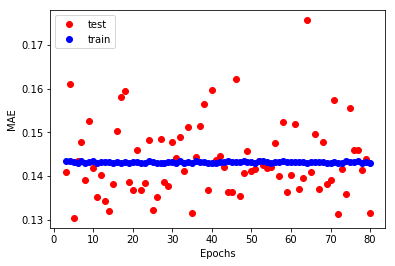

In [33]:
print("NMSE: ")
print(np.mean(nmse))

val_mae_history = [np.mean([x['val_mae'][i] for x in histories]) for i in range(num_epochs)]
mae_history = [np.mean([x['mae'][i] for x in histories]) for i in range(num_epochs)]
plt.plot(range(3, len(val_mae_history) + 1), val_mae_history[2:], 'ro')
plt.plot(range(3, len(mae_history) + 1), mae_history[2:], 'bo')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend(['test', 'train'], loc='upper left')
plt.show()


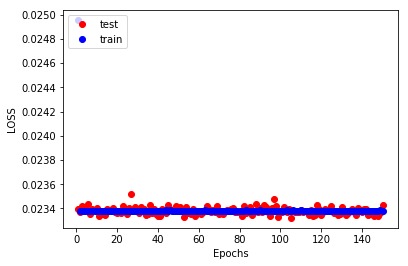

In [20]:
val_loss_history = [np.mean([x['val_loss'][i] for x in histories]) for i in range(num_epochs)]
loss_history = [np.mean([x['loss'][i] for x in histories]) for i in range(num_epochs)]
plt.plot(range(1, len(val_loss_history) + 1), val_loss_history, 'ro')
plt.plot(range(1, len(loss_history) + 1), loss_history, 'bo')
plt.xlabel('Epochs')
plt.ylabel('LOSS')
plt.legend(['test', 'train'], loc='upper left')
plt.show()

# Optimizing number of neurons

In [16]:
k = 3
num_val_samples = len(train_inputs) // k
num_epochs = 75
maes = []
val_maes = []
nmses = []
number_neurons = [2, 5, 8, 12, 16];

for nn in number_neurons:
    mae = []
    val_mae = []
    nmse = []
    print('PROCESSING NUMBER OF NEURONS ', nn);
    for i in range(k):
        print('PROCESSING FOLD #', i)
        val_data = train_inputs[i * num_val_samples: (i + 1) * num_val_samples] 
        val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

        partial_train_data = np.concatenate(
            [train_inputs[:i * num_val_samples],
             train_inputs[(i + 1) * num_val_samples:]], axis=0)
        partial_train_targets = np.concatenate(
            [train_targets[:i * num_val_samples],
             train_targets[(i + 1) * num_val_samples:]], axis=0)


        model = get_model_with(train_inputs, nn)

        history = model.fit(partial_train_data, partial_train_targets,
                            validation_data=(val_data, val_targets),
                            epochs=num_epochs, batch_size=1, verbose=1)
        mae.append(history.history['mae'])
        val_mae.append(history.history['val_mae'])
        predictions_targets = model.predict(val_data)
        nmse.append(np.mean((predictions_targets - val_targets)**2)/np.var(val_targets))
        
    maes.append(np.mean([x[num_epochs-1] for x in mae]))
    val_maes.append(np.mean([x[num_epochs-1] for x in val_mae]))
    nmses.append(np.mean(nmse))


PROCESSING NUMBER OF NEURONS  2
PROCESSING FOLD # 0
Train on 26136 samples, validate on 13068 samples
Epoch 1/75
26136/26136 [==============================] - 29s 1ms/step - loss: 0.0240 - mae: 0.1253 - val_loss: 0.0234 - val_mae: 0.1249
Epoch 2/75
26136/26136 [==============================] - 26s 1ms/step - loss: 0.0233 - mae: 0.1246 - val_loss: 0.0234 - val_mae: 0.1249
Epoch 3/75
26136/26136 [==============================] - 26s 1ms/step - loss: 0.0233 - mae: 0.1246 - val_loss: 0.0234 - val_mae: 0.1250
Epoch 4/75
26136/26136 [==============================] - 26s 1000us/step - loss: 0.0233 - mae: 0.1246 - val_loss: 0.0234 - val_mae: 0.1248
Epoch 5/75
26136/26136 [==============================] - 29s 1ms/step - loss: 0.0233 - mae: 0.1246 - val_loss: 0.0234 - val_mae: 0.1251
Epoch 6/75
26136/26136 [==============================] - 30s 1ms/step - loss: 0.0233 - mae: 0.1246 - val_loss: 0.0234 - val_mae: 0.1254
Epoch 7/75
26136/26136 [==============================] - 29s 1ms/step - 

KeyboardInterrupt: 

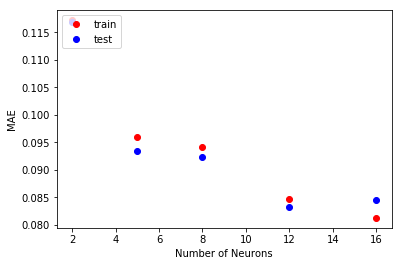

In [31]:
plt.plot(number_neurons, maes, 'ro')
plt.plot(number_neurons, val_maes, 'bo')
plt.xlabel('Number of Neurons')
plt.ylabel('MAE')
plt.legend(['train', 'test'], loc='upper left')

Text(0, 0.5, 'NMSE')

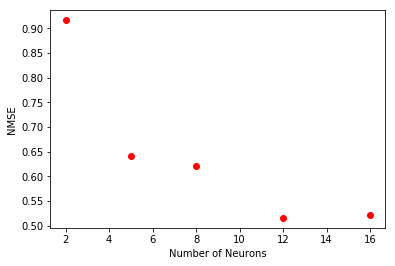

In [32]:
plt.plot(number_neurons, nmses, 'ro')
plt.xlabel('Number of Neurons')
plt.ylabel('NMSE')

In [14]:
model = get_model_with(inputs, 12)

history = model.fit(inputs, targets, epochs=75, batch_size=1, verbose=1)
history.history['mae']
model.save("nn_12_75.h5")

Epoch 1/75
27130/65341 [===========>..................] - ETA: 31s - loss: 0.0251 - mae: 0.1267

KeyboardInterrupt: 

# [X, Y] model

In this part, a neural network is trained using (x,y) coordinates only.

In [8]:
# neural network with a 12-neuron hidden layer
model = models.Sequential()
model.add(layers.Dense(12, activation='relu',
                       input_shape=(2,)))
model.add(layers.Dense(8))
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

k = 5
num_val_samples = len(train_inputs) // k
train_inputs_xy = train_inputs[['x', 'y']]
validation_scores = []
num_epochs = 75
histories = []
nmse = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_inputs_xy[i * num_val_samples: (i + 1) * num_val_samples] 
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_inputs_xy[:i * num_val_samples],
         train_inputs_xy[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]], axis=0)
    
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=1)
    histories.append(history.history)
    
    predictions_targets = model.predict(val_data)
    nmse.append(np.mean((predictions_targets - val_targets)**2)/np.var(val_targets))

processing fold # 0
Instructions for updating:
Use tf.cast instead.
Train on 31364 samples, validate on 7840 samples
Epoch 1/75
31364/31364 [==============================] - 26s 827us/step - loss: 0.0236 - mae: 0.1236 - val_loss: 0.0235 - val_mae: 0.1238
Epoch 2/75
31364/31364 [==============================] - 27s 861us/step - loss: 0.0236 - mae: 0.1241 - val_loss: 0.0236 - val_mae: 0.1239
Epoch 3/75
31364/31364 [==============================] - 25s 806us/step - loss: 0.0238 - mae: 0.1248 - val_loss: 0.0260 - val_mae: 0.1292
Epoch 4/75
31364/31364 [==============================] - 25s 801us/step - loss: 0.0239 - mae: 0.1252 - val_loss: 0.0242 - val_mae: 0.1262
Epoch 5/75
31364/31364 [==============================] - 31s 987us/step - loss: 0.0238 - mae: 0.1256 - val_loss: 0.0238 - val_mae: 0.1267
Epoch 6/75
31364/31364 [==============================] - 28s 902us/step - loss: 0.0238 - mae: 0.1256 - val_loss: 0.0239 - val_mae: 0.1258
Epoch 7/75
31364/31364 [=========================

KeyboardInterrupt: 